In [1]:
import numpy as np
import pandas as pd

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

- データセットのダウンロード

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

- データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

- 平滑化

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [5]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

- 画像データの可視化

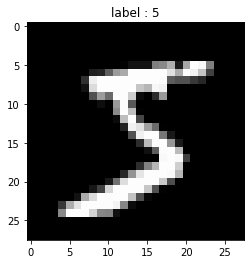

In [6]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

- 前処理

In [7]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [8]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape, y_train.shape) # (48000, 784)
print(X_val.shape, y_val.shape) # (12000, 784)

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)


In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    ディープニューラルネットワーク分類器

    Parameters
    --------------
    activaiton : {'sigmoid', 'tanh', 'relu'} 
        活性化関数の種類
    n_layers : int
        層の数
    n_output : int
        出力層の数
    alpha : float
        学習率
    optimizer :  {'sgd', 'adagrad'}
        最適化手法の種類
        
    Attributes
    -------------
    FC[n_layers] :  dict
        結合層を管理する辞書
    activation : dict
        活性化関数を管理する辞書
    self.epochs : int
        エポック数(初期値：10)
    self.batch_size : int
        バッチサイズ(初期値：20)
    self.n_features : int
        特徴量の数
    self.val_is_true : boolean
        検証用データの有無    
    self.loss : 空のndarray
        訓練データに対する損失の記録
    self.loss_val : 空のndarray
        検証データに対する損失の記録
        
    """    
    def __init__(self, activation, n_layers, n_output, lr, optimizer):
        self.select_activation = activation
        self.n_layers = n_layers
        self.n_output = n_output
        self.lr = lr
        self.select_optimizer = optimizer
            
    def __initialize_n_layers(self):
        """
        N層を初期化する。
        sigmoid関数とtanh関数が活性化関数の場合：Xavierを初期値
        ReLU関数が活性化関数の場合：Heを初期値
        """
        self.activation = dict()
        self.FC = dict()
        
        for n_layer in range(self.n_layers):
            n_nodes = self.n_features // (2**n_layer)
            
            if n_layer == self.n_layers - 1:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(n_nodes, self.n_output, XavierInitializer(), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(n_nodes, self.n_output, XavierInitializer(), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(n_nodes, self.n_output, HeInitializer(), self.optimizer)
                    self.activation[n_layer + 1] = Softmax()                    
            else:
                if self.select_activation == 'sigmoid':
                    self.FC[n_layer + 1] = FC(n_nodes, n_nodes // 2, XavierInitializer(), self.optimizer)
                    self.activation[n_layer + 1] = Sigmoid()
                elif self.select_activation == 'tanh':
                    self.FC[n_layer + 1] = FC(n_nodes, n_nodes // 2, XavierInitializer(), self.optimizer)
                    self.activation[n_layer + 1] = Tanh()
                elif self.select_activation == 'relu':
                    self.FC[n_layer + 1] = FC(n_nodes, n_nodes // 2, HeInitializer(), self.optimizer)
                    self.activation[n_layer + 1] = ReLU()
    
    def fit(self, X, y, epochs=10, batch_size=20):
        self.n_features = X.shape[1]               # 特徴量の数(784)         
        self.epochs = epochs                            # エポック数     
        self.batch_size = batch_size               # バッチサイズ
        self.loss = np.zeros(self.epochs)        # 学習曲線・目的関数の出力用(訓練データ)
        self.loss_val = np.zeros(self.epochs) # 学習曲線・目的関数の出力用(検証データ)        
        
        if self.select_optimizer == 'sgd':
            self.optimizer = SGD(self.lr)
        elif self.select_optimizer == 'adagrad':
            self.optimizer = AdaGrad(self.lr)            
        
        self.__initialize_n_layers()

        for epoch in range(self.epochs):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            print("epoch ", epoch + 1 , " processing . . .")
            for mini_X_train,  mini_y_train in get_mini_batch:
                self.X_ = mini_X_train
                self.y_ = mini_y_train
                
                # フォワードプロバゲーション
                self.A = self.FC[1].forward(self.X_)            #1層目
                self.Z = self.activation[1].forward(self.A) #1層目      
                for n_layer in range(2, self.n_layers + 1): #2層目以降
                    self.A = self.FC[n_layer].forward(self.Z)
                    self.Z = self.activation[n_layer].forward(self.A)
                
                # バックプロパゲーション
                self.dA, self.loss[epoch] = self.activation[self.n_layers].backward(self.Z, self.y_) #最終層, 交差エントロピー誤差
                self.dZ = self.FC[self.n_layers].backward(self.dA) #最終層
                for n_layer in reversed(range(2, self.n_layers)): #最終層 - 1
                        self.dA = self.activation[n_layer].backward(self.dZ)
                        self.dZ = self.FC[n_layer].backward(self.dA)
                                    
    def predict(self,X):
        # フォワードプロバゲーション
        self.A = self.FC[1].forward(X)                     #1層目
        self.Z = self.activation[1].forward(self.A) #1層目
        for n_layer in range(2, self.n_layers + 1): #2層目以降
            self.A = self.FC[n_layer].forward(self.Z)
            self.Z = self.activation[n_layer].forward(self.A)
        
        return np.argmax(self.Z, axis=1)

### 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンス`self`を渡すこともできます。これを利用して`self.optimizer.update(self)`という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

In [12]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        return np.dot(self.X, self.W) + self.B
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)

        # 更新
        self = self.optimizer.update(self)
        
        return dZ

### 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

## 【問題6】重みの初期値

In [13]:
class XavierInitializer:
    """
    Xavierのクラス
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2)
        
        return B

In [14]:
class HeInitializer:
    """
    Heのクラス
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
        
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.random.randn(n_nodes2)#np.zeros(n_nodes2)
        
        return B

## 【問題３】最適化方法のクラス化
全結合層にあるbackwardのself.optimizer.update(self)で学習できるようにしましょう。

## 【問題7】最適化手法
最適化手法には様々なものがあります。発展的なものの中でも比較的実装が簡単なAdaGradを実装してみましょう。

In [15]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        
        Returns
        ----------
        layer : 更新後の層のインスタンス
        """        
        layer.W = layer.W - self.lr * layer.dW
        layer.B = layer.B - self.lr * layer.dB
        
        return layer

In [16]:
class AdaGrad:
    """
    AdaGradのクラス
    Parameters
    ----------
    alpha : 学習率
    
    Attributes
    -------------
    lr : 学習率
    HW : int(初期値), ndarray
    HB :  int(初期値), ndarray
    """    
    def __init__(self, lr):
        self.lr = lr
        self.HW= 0 # 初期値：0
        self.HB = 0 # 初期値：0       

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : インスタンス
            更新前の層のインスタンス

        Returns
        ----------
        layer : インスタンス
            更新後の層のインスタンス
        """
        #初期化
        self.HW = np.zeros_like(layer.W)
        self.HB = np.zeros_like(layer.B)
        
        #更新    
        self.HW = self.HW + (layer.dW**2) #/ layer.dB.shape[0]
        self.HB = self.HB + (layer.dB**2) #.mean(axis=0)) ** 2
        layer.W = layer.W - self.lr * 1 / np.sqrt(self.HW + 1e-7) * layer.dW #/ layer.dB.shape[0]
        layer.B = layer.B - self.lr * 1 / np.sqrt(self.HB + 1e-7) * layer.dB #.mean(axis=0)
        
        return layer

## 【問題4】活性化関数のクラス化

In [17]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        self.Z = 1.0 / (1.0 + np.exp(-self.A))
        
        return self.Z
    
    def backward(self, dZ):

        return dZ * (1 - self.Z) * self.Z

In [18]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        
        return np.tanh(self.A)
    
    def backward(self, dZ):
        
        return dZ * (1.0 - (np.tanh(self.A) ** 2))

In [19]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        
        return np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
    
    def backward(self, Z, y):
        
        dA = Z - y
        
        # 交差エントロピー誤差
        batch_size = y.shape[0]
        loss = -np.sum(y * np.log(Z)) / batch_size

        return dA, loss

## 【問題5】ReLUクラスの作成
発展的な活性化関数を作成しましょう。ReLUという活性化関数によって、勾配消失の問題が解消され、層のディープ化が可能になりました。

\begin{align}
    f(x) = ReLU(x) = 
    \begin{cases}
        x　　(x>0)  \\
        0　　(x\leq0)
    \end{cases}  \\
    \frac{\partial f(x)}{\partial x} =
    \begin{cases}
        1　　(x>0) \\
        0　　(x\leq0)
    \end{cases}
\end{align}
本来、解析的には$x=0$で微分不可ですが、$f'(x=0)=0$とすることで対応しています。

In [20]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, A):    
        self.A = A
      
        return np.maximum(self.A, 0)
    
    def backward(self, dZ):
            
        return np.where(self.A > 0, dZ, 0)

## 【問題8】クラスの完成
モデル全体を設計するクラスを完成させてください。

## 【問題9】学習と推定
ノード数や層の数、活性化関数を変えたネットワークを作成して、それぞれの結果を比較してみてください。

In [21]:
model = ScratchDeepNeuralNetrowkClassifier(activation='sigmoid', n_layers=4, n_output=10, lr=0.001, optimizer='adagrad')
model.fit(X_train, y_train, epochs=5, batch_size=20)
y_pred = model.predict(X_test)

epoch  1  processing . . .
epoch  2  processing . . .
epoch  3  processing . . .
epoch  4  processing . . .
epoch  5  processing . . .


In [22]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [23]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.8668


              precision    recall  f1-score   support

           0       0.95      0.94      0.94       980
           1       0.86      0.99      0.92      1135
           2       0.88      0.84      0.86      1032
           3       0.88      0.88      0.88      1010
           4       0.86      0.89      0.88       982
           5       0.77      0.81      0.79       892
           6       0.81      0.95      0.87       958
           7       0.95      0.80      0.87      1028
           8       0.93      0.73      0.81       974
           9       0.81      0.81      0.81      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000



In [24]:
model = ScratchDeepNeuralNetrowkClassifier(activation='relu', n_layers=4, n_output=10, lr=0.001, optimizer='sgd')
model.fit(X_train, y_train, epochs=10, batch_size=20)
y_pred = model.predict(X_test)

epoch  1  processing . . .
epoch  2  processing . . .
epoch  3  processing . . .
epoch  4  processing . . .
epoch  5  processing . . .
epoch  6  processing . . .
epoch  7  processing . . .
epoch  8  processing . . .
epoch  9  processing . . .
epoch  10  processing . . .


In [25]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [26]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.9463


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.93      0.96      1032
           3       0.91      0.98      0.94      1010
           4       0.98      0.87      0.92       982
           5       0.93      0.96      0.94       892
           6       0.98      0.95      0.96       958
           7       0.94      0.95      0.95      1028
           8       0.97      0.89      0.93       974
           9       0.84      0.97      0.90      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [27]:
model = ScratchDeepNeuralNetrowkClassifier(activation='tanh', n_layers=5, n_output=10, lr=0.001, optimizer='adagrad')
model.fit(X_train, y_train, epochs=15, batch_size=20)
y_pred = model.predict(X_test)

epoch  1  processing . . .
epoch  2  processing . . .
epoch  3  processing . . .
epoch  4  processing . . .
epoch  5  processing . . .
epoch  6  processing . . .
epoch  7  processing . . .
epoch  8  processing . . .
epoch  9  processing . . .
epoch  10  processing . . .
epoch  11  processing . . .
epoch  12  processing . . .
epoch  13  processing . . .
epoch  14  processing . . .
epoch  15  processing . . .


In [28]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [29]:
print("accuracy : {}".format(accuracy_score(y_test, y_pred)))
print("\n")
print(classification_report(y_test, y_pred))

accuracy : 0.9675


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.94      0.98      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.95      0.96       892
           6       0.98      0.97      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

